# NO2 Multi-day Forecast Pipeline
Notebook ini menjalankan pipeline:
- Load CSV (atau generate synthetic jika tidak ada)
- Eksplorasi & ACF
- Feature engineering (lag 1..14)
- Time-based split
- Normalisasi MinMax
- Train KNN & RandomForest (MultiOutput)
- Evaluasi per-horizon (MAE, RMSE, MAPE)
- Simpan `predictions.csv`, model & scaler
- Contoh Flask deploy

Default: max_lag=14, horizon=7, test_days=60

### Import library

In [1]:
# Cell 2: Import libraries
%matplotlib inline
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib

from statsmodels.graphics.tsaplots import plot_acf


### Load CSV (atau generate jika tidak ada) & tampilan awal

In [2]:
# Cell 3: Load CSV atau generate synthetic
CSV_PATH = "no2_data.csv"

if os.path.exists(CSV_PATH):
    df = pd.read_csv(CSV_PATH, parse_dates=["date"])
    print(f"Loaded {CSV_PATH} with {len(df)} rows.")
else:
    # Generate synthetic daily data (contoh)
    rng = pd.date_range("2024-01-01", "2025-12-31", freq="D")
    np.random.seed(42)
    seasonal = 10 + 5 * np.sin(2 * np.pi * rng.dayofyear / 365.25)
    trend = 0.002 * np.arange(len(rng))
    noise = np.random.normal(scale=1.5, size=len(rng))
    no2 = seasonal + trend + noise
    df = pd.DataFrame({"date": rng, "NO2": no2})
    df.to_csv(CSV_PATH, index=False)
    print(f"No CSV found — created synthetic and saved to {CSV_PATH} ({len(df)} rows).")

df = df.sort_values("date").reset_index(drop=True)
df["date"] = pd.to_datetime(df["date"])
df = df.set_index("date")
df.head()


No CSV found — created synthetic and saved to no2_data.csv (731 rows).


,NO2
date,
2024-01-01,10.831079
2024-01-02,9.966594
2024-01-03,11.233455
2024-01-04,12.634322
2024-01-05,10.086300


### Visualisasi awal time series

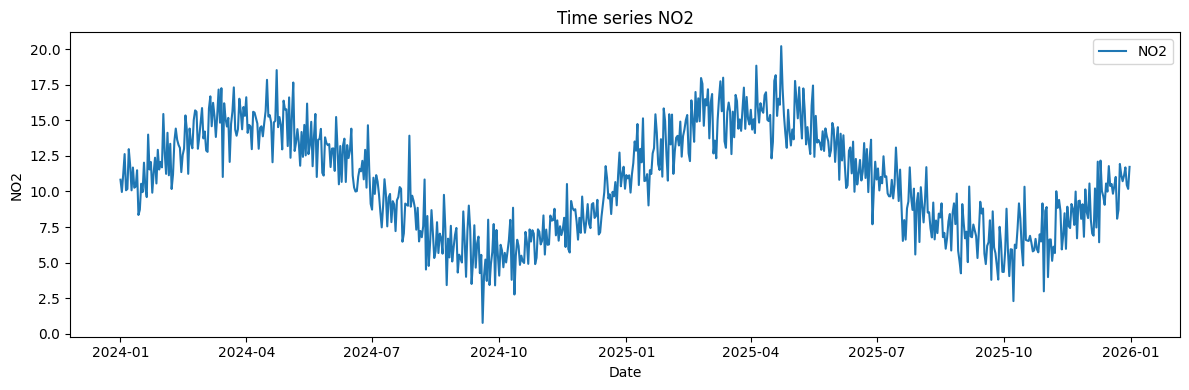

In [3]:
# Cell 4: Plot time series NO2
plt.figure(figsize=(12,4))
plt.plot(df.index, df["NO2"], label="NO2")
plt.title("Time series NO2")
plt.xlabel("Date")
plt.ylabel("NO2")
plt.legend()
plt.tight_layout()
plt.show()


### Cek autocorrelation & plot ACF

Autocorrelation (lag 1..14):
lag 1: 0.832
lag 2: 0.834
lag 3: 0.838
lag 4: 0.821
lag 5: 0.838
lag 6: 0.833
lag 7: 0.828
lag 8: 0.823
lag 9: 0.830
lag 10: 0.828
lag 11: 0.830
lag 12: 0.824
lag 13: 0.819
lag 14: 0.810


<Figure size 1000x400 with 0 Axes>

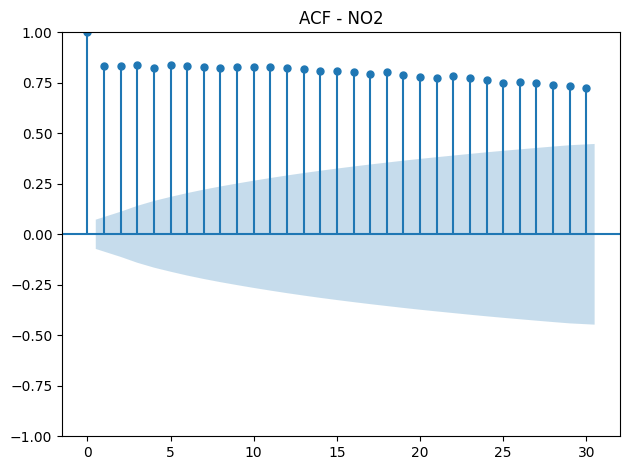

In [4]:
# Cell 5: Autocorrelation numeric + ACF plot
print("Autocorrelation (lag 1..14):")
for lag in range(1, 15):
    print(f"lag {lag}: {df['NO2'].autocorr(lag=lag):.3f}")

plt.figure(figsize=(10,4))
plot_acf(df["NO2"], lags=30)
plt.title("ACF - NO2")
plt.tight_layout()
plt.show()


### Feature engineering (lag 1..14) dan target multi-step

In [5]:
# Cell 6: Feature engineering
MAX_LAG = 14
HORIZON = 7   # default 7 hari ke depan

data = df.copy()
for lag in range(1, MAX_LAG+1):
    data[f"lag_{lag}"] = data["NO2"].shift(lag)

for h in range(1, HORIZON+1):
    data[f"y_plus_{h}"] = data["NO2"].shift(-h)

data = data.dropna().copy()
print(f"Data after lag/target creation: {data.shape}")
data.head()


Data after lag/target creation: (710, 22)


,NO2,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_12,lag_13,lag_14,y_plus_1,y_plus_2,y_plus_3,y_plus_4,y_plus_5,y_plus_6,y_plus_7
date,,,,,,,,,,,,,,,,,,,,,
2024-01-15,8.716535,8.348643,11.495804,10.348236,10.265371,11.687725,10.082809,11.851079,12.981450,10.173951,...,11.233455,9.966594,10.831079,10.545452,9.954207,12.028967,10.279252,9.606050,14.005697,11.550754
2024-01-16,10.545452,8.716535,8.348643,11.495804,10.348236,10.265371,11.687725,10.082809,11.851079,12.981450,...,12.634322,11.233455,9.966594,9.954207,12.028967,10.279252,9.606050,14.005697,11.550754,12.072359
2024-01-17,9.954207,10.545452,8.716535,8.348643,11.495804,10.348236,10.265371,11.687725,10.082809,11.851079,...,10.086300,12.634322,11.233455,12.028967,10.279252,9.606050,14.005697,11.550754,12.072359,9.915023
2024-01-18,12.028967,9.954207,10.545452,8.716535,8.348643,11.495804,10.348236,10.265371,11.687725,10.082809,...,10.173951,10.086300,12.634322,10.279252,9.606050,14.005697,11.550754,12.072359,9.915023,11.316055
2024-01-19,10.279252,12.028967,9.954207,10.545452,8.716535,8.348643,11.495804,10.348236,10.265371,11.687725,...,12.981450,10.173951,10.086300,9.606050,14.005697,11.550754,12.072359,9.915023,11.316055,12.378881


### Split train-test (time-based)

In [6]:
# Cell 7: Time-based split
TEST_DAYS = 60

# Pastikan ada cukup data
train_end = data.index[-(TEST_DAYS + HORIZON)]
train = data.loc[:train_end].copy()
test = data.loc[train_end + pd.Timedelta(days=1):].copy()

print(f"Train rows: {len(train)}, Test rows: {len(test)}")
feature_cols = [f"lag_{i}" for i in range(1, MAX_LAG+1)]
target_cols = [f"y_plus_{h}" for h in range(1, HORIZON+1)]

X_train = train[feature_cols].values
y_train = train[target_cols].values
X_test = test[feature_cols].values
y_test = test[target_cols].values


Train rows: 644, Test rows: 66


### Normalisasi MinMax (fit di train)

In [7]:
# Cell 8: Normalisasi MinMax
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_s = scaler_X.fit_transform(X_train)
X_test_s = scaler_X.transform(X_test)
y_train_s = scaler_y.fit_transform(y_train)

# Simpan scaler (opsional)
joblib.dump(scaler_X, "scaler_X.joblib")
joblib.dump(scaler_y, "scaler_y.joblib")
print("Scalers saved: scaler_X.joblib, scaler_y.joblib")


Scalers saved: scaler_X.joblib, scaler_y.joblib


### Train Model: KNN (MultiOutput)

In [8]:
# Cell 9: Train KNN (MultiOutput)
knn = MultiOutputRegressor(KNeighborsRegressor(n_neighbors=5))
knn.fit(X_train_s, y_train_s)
joblib.dump(knn, "model_knn_multioutput.joblib")
print("KNN trained & saved: model_knn_multioutput.joblib")


KNN trained & saved: model_knn_multioutput.joblib


### Train Model: Random Forest (MultiOutput)

In [9]:
# Cell 10: Train RandomForest (MultiOutput)
rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))
rf.fit(X_train_s, y_train_s)
joblib.dump(rf, "model_rf_multioutput.joblib")
print("Random Forest trained & saved: model_rf_multioutput.joblib")

Random Forest trained & saved: model_rf_multioutput.joblib


### Evaluasi: MAE, RMSE, MAPE per horizon

In [ ]:
# Cell 11: Evaluasi

def mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = y_true != 0
    if not mask.any():
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Prediksi (skala)
y_pred_knn_s = knn.predict(X_test_s)
y_pred_rf_s = rf.predict(X_test_s)

# Invers transform
y_pred_knn = scaler_y.inverse_transform(y_pred_knn_s)
y_pred_rf = scaler_y.inverse_transform(y_pred_rf_s)

# Hitung metrik per horizon
metrics = []
for model_name, y_pred in [("KNN", y_pred_knn), ("RF", y_pred_rf)]:
    for h in range(HORIZON):
        mae = mean_absolute_error(y_test[:,h], y_pred[:,h])
        rmse = mean_squared_error(y_test[:,h], y_pred[:,h]) ** 0.5   
        mpe = mape(y_test[:,h], y_pred[:,h])
        metrics.append({"model": model_name, "horizon_day": h+1, "MAE": mae, "RMSE": rmse, "MAPE": mpe})


### Plot hasil aktual vs prediksi (1-day dan HORIZON-day)

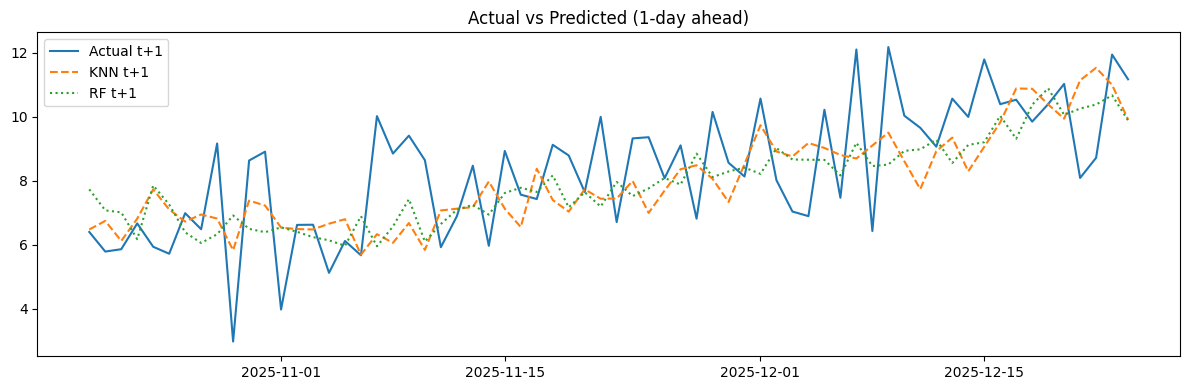

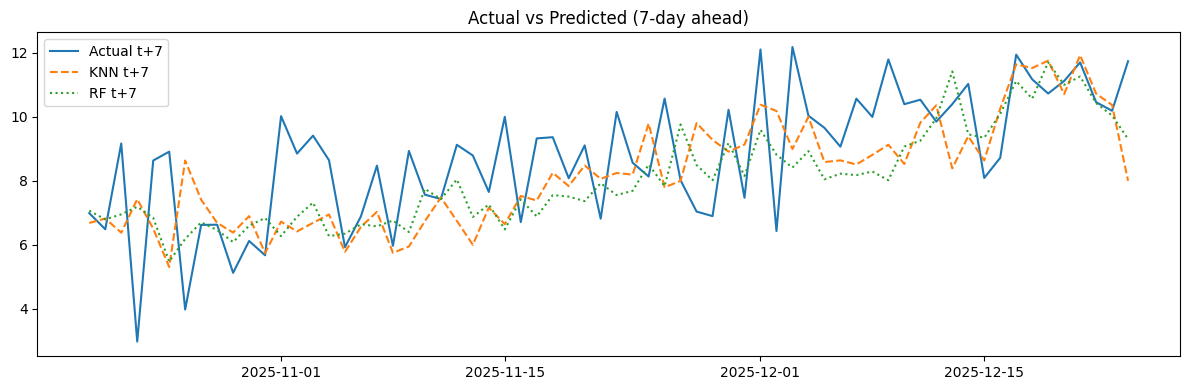

In [13]:
# Cell 12: Visualisasi hasil
test_dates = test.index[:len(y_pred_knn)]

# 1-day ahead
plt.figure(figsize=(12,4))
plt.plot(test_dates, y_test[:,0], label="Actual t+1")
plt.plot(test_dates, y_pred_knn[:,0], '--', label="KNN t+1")
plt.plot(test_dates, y_pred_rf[:,0], ':', label="RF t+1")
plt.title("Actual vs Predicted (1-day ahead)")
plt.legend()
plt.tight_layout()
plt.show()

# horizon (misal 7-day)
plt.figure(figsize=(12,4))
plt.plot(test_dates, y_test[:,HORIZON-1], label=f"Actual t+{HORIZON}")
plt.plot(test_dates, y_pred_knn[:,HORIZON-1], '--', label=f"KNN t+{HORIZON}")
plt.plot(test_dates, y_pred_rf[:,HORIZON-1], ':', label=f"RF t+{HORIZON}")
plt.title(f"Actual vs Predicted ({HORIZON}-day ahead)")
plt.legend()
plt.tight_layout()
plt.show()


### Simpan hasil prediksi ke CSV

In [14]:
# Cell 13: Simpan predictions.csv
results = pd.DataFrame({"date": test_dates})
for h in range(HORIZON):
    results[f"actual_t_plus_{h+1}"] = y_test[:,h]
    results[f"pred_knn_t_plus_{h+1}"] = y_pred_knn[:,h]
    results[f"pred_rf_t_plus_{h+1}"] = y_pred_rf[:,h]

results.to_csv("predictions.csv", index=False)
print("Saved predictions.csv. Sample:")
results.head(10)


Saved predictions.csv. Sample:


,date,actual_t_plus_1,pred_knn_t_plus_1,pred_rf_t_plus_1,actual_t_plus_2,pred_knn_t_plus_2,pred_rf_t_plus_2,actual_t_plus_3,pred_knn_t_plus_3,pred_rf_t_plus_3,...,pred_rf_t_plus_4,actual_t_plus_5,pred_knn_t_plus_5,pred_rf_t_plus_5,actual_t_plus_6,pred_knn_t_plus_6,pred_rf_t_plus_6,actual_t_plus_7,pred_knn_t_plus_7,pred_rf_t_plus_7
0,2025-10-20,6.396291,6.474261,7.728031,5.784133,6.802212,7.141251,5.857514,6.688947,6.926870,...,6.580708,5.933133,7.355894,8.297812,5.716273,6.607923,6.300095,6.983802,6.678113,7.061664
1,2025-10-21,5.784133,6.742348,7.071629,5.857514,6.574493,7.097180,6.663225,7.420634,6.764855,...,8.235305,5.716273,6.744928,6.360068,6.983802,6.671792,6.899524,6.481639,6.816278,6.789088
2,2025-10-22,5.857514,6.115831,7.009166,6.663225,6.890151,6.731692,5.933133,6.837965,8.124127,...,6.195248,6.983802,5.936105,6.879314,6.481639,6.452776,6.581079,9.161365,6.374217,6.947796
3,2025-10-23,6.663225,6.812693,6.170442,5.933133,7.595143,7.769417,5.716273,8.022074,7.173318,...,6.571201,6.481639,6.932922,6.437823,9.161365,6.513382,6.829495,2.971502,7.421183,7.184082
4,2025-10-24,5.933133,7.727476,7.850549,5.716273,7.118457,7.076428,6.983802,6.796971,6.487984,...,6.266298,9.161365,6.348141,6.608519,2.971502,7.267220,7.097834,8.629096,6.500532,6.840160
5,2025-10-25,5.716273,7.099057,7.253447,6.983802,5.911618,6.671809,6.481639,6.442293,6.001776,...,6.496730,2.971502,7.774864,6.903470,8.629096,6.825877,6.686866,8.906129,5.300960,5.472735
6,2025-10-26,6.983802,6.720796,6.385452,6.481639,6.989400,6.056027,9.161365,6.173299,6.476950,...,7.010884,8.629096,7.669297,6.922140,8.906129,5.824507,5.507766,3.973355,8.629161,6.179717
7,2025-10-27,6.481639,6.943025,6.051957,9.161365,6.036164,6.341017,2.971502,7.550061,6.749927,...,6.952031,8.906129,6.195484,5.726578,3.973355,8.121255,6.141610,6.617108,7.404484,6.697641
8,2025-10-28,9.161365,6.815086,6.324833,2.971502,6.164533,6.977021,8.629096,6.485903,6.556407,...,5.737148,3.973355,6.211513,6.510483,6.617108,8.126037,6.970740,6.622924,6.679180,6.455479
9,2025-10-29,2.971502,5.826638,6.911656,8.629096,6.839251,6.545556,8.906129,6.435828,5.778432,...,6.545962,6.617108,8.415258,6.828627,6.622924,6.432332,6.358170,5.118996,6.377857,6.080511


### Contoh Flask deploy file (dibuat otomatis)

In [ ]:
import streamlit as st
import numpy as np
import joblib
import pandas as pd
import matplotlib.pyplot as plt

# ======================
# LOAD MODEL & SCALER
# ======================
model = joblib.load("model_rf_multioutput.joblib")
scaler_X = joblib.load("scaler_X.joblib")
scaler_y = joblib.load("scaler_y.joblib")

st.title("🌫️ Prediksi NO₂ - 7 Hari ke Depan")
st.write("Masukkan 14 nilai lag (lag_1 sampai lag_14) untuk memprediksi kadar NO₂ selama 7 hari ke depan.")

# ======================
# INPUT FORM
# ======================
lags = []
cols = st.columns(7)

for i in range(14):
    with cols[i % 7]:
        val = st.number_input(f"Lag {i+1}", value=0.0, step=0.1, format="%.3f")
        lags.append(val)

if st.button("🔍 Prediksi"):
    if len(lags) == 14:
        X_input = np.array(lags).reshape(1, -1)
        X_scaled = scaler_X.transform(X_input)

        pred_scaled = model.predict(X_scaled)
        pred = scaler_y.inverse_transform(pred_scaled)[0]

        future_days = [f"Hari {i+1}" for i in range(7)]
        df_result = pd.DataFrame({"Hari": future_days, "Prediksi NO2": pred})

        st.success("✅ Prediksi berhasil!")
        st.dataframe(df_result)

        # ======================
        # VISUALISASI GRAFIK
        # ======================
        plt.figure(figsize=(8,4))
        plt.plot(future_days, pred, marker="o")
        plt.xlabel("Hari ke-")
        plt.ylabel("Kadar NO₂ (µg/m³)")
        plt.title("Prediksi NO₂ untuk 7 Hari ke Depan")
        st.pyplot(plt)

    else:
        st.error("❌ Input tidak lengkap. Harus ada 14 nilai lag!")

st.caption("Model: Random Forest MultiOutput | Scaler: MinMaxScaler")

Saved Flask example: app_flask_deploy_example.py
Selesai. File yang dibuat: predictions.csv, model_* .joblib, scaler_*.joblib, app_flask_deploy_example.py


### Implementasi NO2 Multi-day Forecast Pipeline Menggunakan Streamlit
Implementasi ini dilakukan dengan membangun antarmuka interaktif menggunakan Streamlit, yaitu framework berbasis Python untuk membuat aplikasi web data science secara cepat dan sederhana. 

Hasil Prediksi:

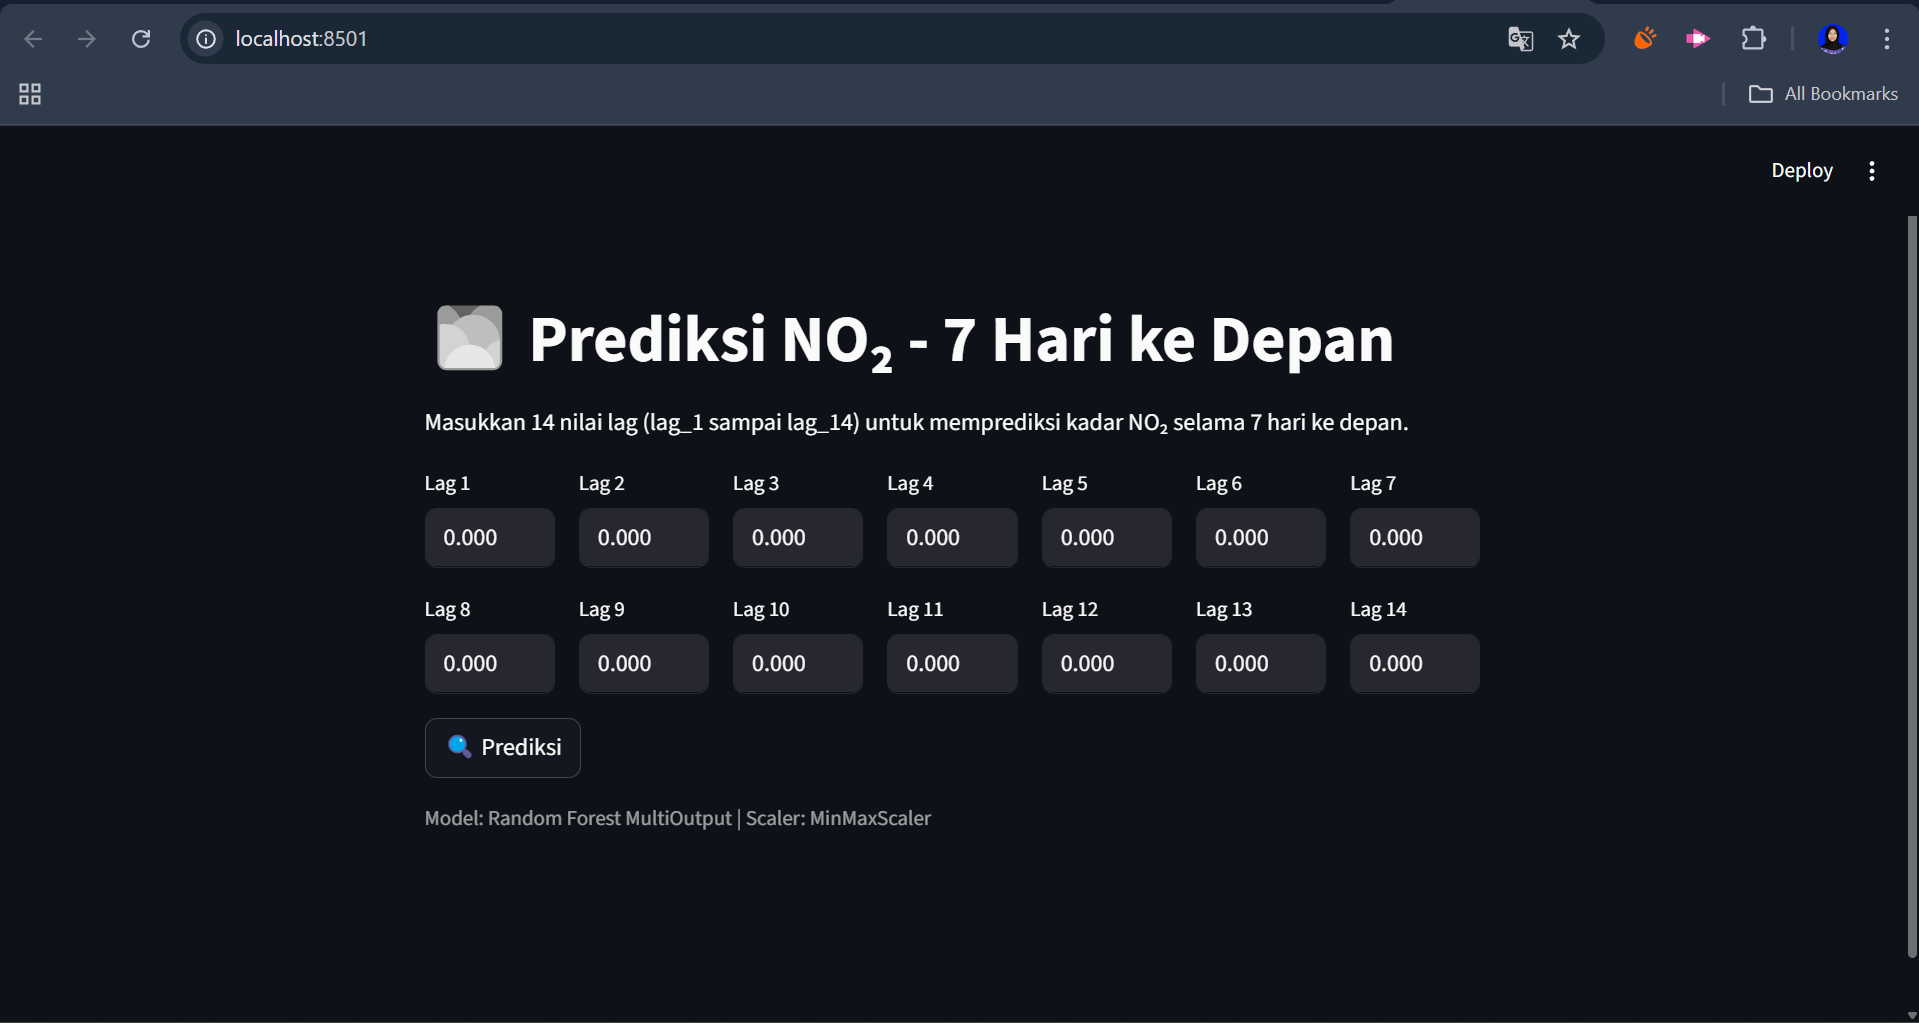